## Please don't run / don't click "Run all" the notebook:</br>
At the time of writing of this document, the current core limit per workspace is limited and depending upon number of concurrent users, you may end up with core capacity being exceeded or maximum number of parallel jobs being exceeded error.

# Exploratory Data Analysis (EDA) and Feature Engineering with Tax Fraud Detection Dataset

### Introduction

In this notebook we show how to do **exploratory data analysis**, **data preparation** and **feature engineering** on tax fraud dataset. At the end 
of this notebook, we are saving the processed dataset in ADLSGen2 to be used for building fraud detection model.

<h3>Description of Data</h3> <br>

The tax fraud dataset contains a total of 663276 records and 31 data fields. Within the 31 data fields,
there are 13 numerical data fields and 18 categorical data fields. Summary tables for the numerical and
categorical data fields can be seen in the Table. 

|LABEL         |FORMAT          |DESCRIPTION   |
|:---:          | :----:         | ---:   |
|BBLE	       |Text	        |one field with bble in text format&emsp;|
|B	           |Byte	        |borough valid values 1-5&emsp;|
|BLOCK	       |&emsp;Long Integer&emsp;	|   |
|LOT	       |&emsp;Long Integer	&emsp;|   |
|EASEMENT      |Text	        |   |
|OWNER	       |Text	        |owner name&emsp;|
|BLDGCL	       |Text	        |building class&emsp;|
|TAXCLASS      |Text	        |tax class&emsp;|
|LTFRONT	   |Text	        |lot width&emsp;|
|LTDEP	       |Text	        |lot depth&emsp;|
|EXT	       |Text     	    |extension indicator&emsp;|
|STORIES	   |Text	        |number of stories in building&emsp;|
|FULLVAL	   |Double	        |market value&emsp;|
|AVLAND	       |Double	        |actual land value&emsp;|
|AVTOT	       |Double	        |actual total value&emsp;|
|EXLAND	       |Double	        |actual exempt land value&emsp;|
|EXTOT	       |Double	        |actual exemtp land total&emsp;|
|EXCD1	       |Text	        |exemption code 1&emsp;|
|STADDR	       |Text	        |street address&emsp;|
|ZIP	       |Text	        |zip code&emsp;|
|EXMPTCL	   |Text	        |exempt class&emsp;|
|BLDFRONT      |Text	        |building width&emsp;|
|BLDDEPTH      |Text	        |building depth&emsp;|
|AVLAND2	   |Double	        |transitional land value&emsp;|
|AVTOT2	       |Double	        |transitional total value&emsp;|
|EXLAND2	   |Double	        |transitional exempt land value&emsp;|
|EXTOT2	       |Double	        |transitional exempt land total&emsp;|
|EXCD2	       |Text	        |exemption code 2&emsp;|
|PERIOD	       |Text	        |&emsp;assessment period when file was created&emsp;|
|YEAR	       |Text	        |assessment year&emsp;|


<h2>Importing libraries</h2>

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from azure.storage.blob import ContainerClient, BlobClient
import pandas as pd
from io import BytesIO
from copy import deepcopy

StatementMeta(#SPARK_POOL_NAME#, 42, 1, Finished, Available)

<h2> Creating connection & reading data  </h2>

In [2]:
CONNECTIONSTRING = 'DefaultEndpointsProtocol=https;AccountName=#STORAGE_ACCOUNT_NAME#;AccountKey=#STORAGE_ACCOUNT_KEY#;EndpointSuffix=core.windows.net'
CONTAINER_NAME = 'fraud-detection-sample-nyrealestate'

BLOBNAME = 'Fraud_Detection_NYC_Data.csv'
blob = BlobClient.from_connection_string(conn_str=CONNECTIONSTRING, container_name=CONTAINER_NAME, blob_name=BLOBNAME)
blob_data = blob.download_blob()
BytesIO(blob_data.content_as_bytes())
data = pd.read_csv(BytesIO(blob_data.content_as_bytes()))

StatementMeta(#SPARK_POOL_NAME#, 42, 2, Finished, Available)

<h2>Describing Data</h2>

In [3]:
data.describe(include = 'all')

StatementMeta(#SPARK_POOL_NAME#, 42, 3, Finished, Available)

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
count,663276,663276.000000,663276.000000,663276.000000,2010,638014,663276,663276,663276.000000,663276.000000,149682,631947.000000,6.632760e+05,6.632760e+05,6.632760e+05,6.632760e+05,6.632760e+05,364432.000000,662887,650945.000000,10287,663275.000000,663275.000000,2.423170e+05,2.423170e+05,7.389700e+04,1.143670e+05,48224.000000,663275,663275,663275
unique,663276,NaN,NaN,NaN,12,525355,199,11,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,475418,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
top,3065720025,NaN,NaN,NaN,E,PARKCHESTER PRESERVAT,R4,1,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501 SURF AVENUE,NaN,X1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
freq,1,NaN,NaN,NaN,1783,6021,128039,330829,NaN,NaN,102451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,902,NaN,4257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663275,663275,663275
mean,NaN,2.527798,3348.236095,485.042637,NaN,NaN,NaN,NaN,33.547953,81.905905,NaN,6.651435,1.065319e+06,1.090647e+05,3.110277e+05,4.232230e+04,1.161502e+05,1856.263509,NaN,10845.295941,NaN,23.598804,42.215892,2.415923e+05,7.273416e+05,3.078764e+05,6.009875e+05,1620.465059,NaN,NaN,NaN
std,NaN,0.975214,2457.713935,994.998348,NaN,NaN,NaN,NaN,71.902216,71.575187,NaN,10.152613,1.434205e+07,4.502345e+06,6.449744e+06,4.394188e+06,5.808737e+06,1596.386664,NaN,518.713258,NaN,41.945919,48.675277,5.666181e+06,8.517242e+06,9.870334e+06,1.068026e+07,1384.181130,NaN,NaN,NaN
min,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1010.000000,NaN,10001.000000,NaN,0.000000,0.000000,4.000000e+00,1.300000e+01,1.000000e+00,7.000000e+00,1011.000000,NaN,NaN,NaN
25%,NaN,2.000000,1243.000000,25.000000,NaN,NaN,NaN,NaN,16.000000,59.000000,NaN,2.000000,2.437985e+05,8.174000e+03,1.948800e+04,0.000000e+00,0.000000e+00,1017.000000,NaN,10459.000000,NaN,0.000000,0.000000,6.341000e+03,3.794300e+04,2.090000e+03,2.971000e+03,1017.000000,NaN,NaN,NaN
50%,NaN,3.000000,2702.000000,54.000000,NaN,NaN,NaN,NaN,21.000000,100.000000,NaN,3.000000,4.670000e+05,1.424900e+04,2.904000e+04,0.000000e+00,1.620000e+03,1017.000000,NaN,11207.000000,NaN,20.000000,41.000000,2.047000e+04,8.309200e+04,3.027000e+03,3.792900e+04,1017.000000,NaN,NaN,NaN
75%,NaN,3.000000,5331.000000,1008.000000,NaN,NaN,NaN,NaN,30.000000,100.000000,NaN,5.000000,6.790000e+05,2.288525e+04,7.331100e+04,1.620000e+03,2.650000e+03,1920.000000,NaN,11228.000000,NaN,22.000000,55.000000,6.003000e+04,2.444380e+05,2.836800e+04,1.032960e+05,1017.000000,NaN,NaN,NaN


&emsp;&emsp;&emsp;&emsp;  *The following shows the number of null values in the data split for each column*

In [4]:
data.isnull().sum() 

StatementMeta(#SPARK_POOL_NAME#, 42, 4, Finished, Available)

BBLE             0
B                0
BLOCK            0
LOT              0
EASEMENT    661266
OWNER        25262
BLDGCL           0
TAXCLASS         0
LTFRONT          0
LTDEPTH          0
EXT         513594
STORIES      31329
FULLVAL          0
AVLAND           0
AVTOT            0
EXLAND           0
EXTOT            0
EXCD1       298844
STADDR         389
ZIP          12331
EXMPTCL     652989
BLDFRONT         1
BLDDEPTH         1
AVLAND2     420959
AVTOT2      420959
EXLAND2     589379
EXTOT2      548909
EXCD2       615052
PERIOD           1
YEAR             1
VALTYPE          1
dtype: int64

&emsp;&emsp;&emsp;&emsp; *Describe the data dimensions for the dataset*

In [5]:
data.shape

StatementMeta(#SPARK_POOL_NAME#, 42, 5, Finished, Available)

(663276, 31)

&emsp;&emsp;&emsp;&emsp; *Describe the data types for the dataset*

In [6]:
data.dtypes

StatementMeta(#SPARK_POOL_NAME#, 42, 6, Finished, Available)

BBLE         object
B             int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

# **Data Cleaning**

In [7]:
# Defining numerical and catagorical columns
numData = deepcopy(data)
catData = deepcopy(data)


#transform the columns into a list of string
allCols = data.columns.tolist()



#creating a list of variable names as a list
catCols = ['BBLE','B','BLOCK','LOT','EASEMENT',
            'OWNER','BLDGCL','TAXCLASS','EXT','EXCD1',
            'STADDR','ZIP','EXMPTCL','EXCD2','PERIOD','YEAR','VALTYPE']

numCols = list(set(allCols) - set(catCols))

numData = numData.drop(columns=catCols)
catData = catData.drop(columns=numCols)


#numData consists of a dataframe with all subsequent data after dropping catCols columns

#catData consists of a dataframe with all subsequent data after dropping the columns that are not in catCols

StatementMeta(#SPARK_POOL_NAME#, 42, 7, Finished, Available)

<h1> &emsp; Handling Missing Values<h1>

#### &emsp;&emsp;&emsp;DATA IMPUTATION FOR ZIP Code

In [8]:
# Copy dataframe to keep the df in the original form.
df2 = deepcopy(data)
dropCols_impute = ['BBLE','PERIOD','YEAR','VALTYPE','LOT','EASEMENT','OWNER','EXT','EXCD1','EXMPTCL','EXCD2','AVLAND2','AVTOT2','EXLAND2','EXTOT2']
df2 = df2.drop(columns=dropCols_impute)

StatementMeta(#SPARK_POOL_NAME#, 42, 8, Finished, Available)

#### &emsp;&emsp;&emsp; Filling in missing values in a column

&emsp;&emsp;&emsp;&emsp;'STADDR' is heavily populated with only 389 property records missing a value, as seen above in cell 4

&emsp;&emsp;&emsp;&emsp;This is an important data field,  we will fill the missing values based on location related data fields from the dataset.

In [9]:
# Copy the STADDR data field into a new column and strip out the address numbers 
# from the street address for the purpose of usability



df2['STADDR_temp'] = df2['STADDR']
df2['STADDR_temp'] = df2['STADDR_temp'].str.lstrip('1234567890. ') 
df2[['STADDR','STADDR_temp']].head()

StatementMeta(#SPARK_POOL_NAME#, 42, 9, Finished, Available)

,STADDR,STADDR_temp
0,1 GOVERNORS ISLAND,GOVERNORS ISLAND
1,1 LIBERTY ISLAND,LIBERTY ISLAND
2,1 ELLIS ISLAND,ELLIS ISLAND
3,MARGINAL STREET,MARGINAL STREET
4,PIER 6,PIER 6


&emsp;&emsp;&emsp;&emsp;**Now we use a lambda function to essentially fill the NaN values with dummy values**

&emsp;&emsp;&emsp;&emsp;*A lambda fuction is the same as regular function but it is shorter and it is used for smaller tasks, for example as a filter*

In [10]:
# copy df2 into another dataframe to alter the data fields; this is a throwaway dataframe
df3 = deepcopy(df2) 


# This is a lambda functin to be used with the transform method on the pandas dataframe
f_zip = lambda x: x.mode()[0] if not x.mode().empty else np.nan 
df3['STADDR_temp2'] = df3['STADDR_temp'].fillna('empty') # This will fill the NaN values with a dummy value 



# Group by B, BLOCK, STADDR_temp2, then find the mode for the ZIP
df3['ZIP2'] = df3['ZIP'].fillna(df3.groupby(['B','BLOCK','STADDR_temp2'])['ZIP'].transform(f_zip)) 

StatementMeta(#SPARK_POOL_NAME#, 42, 10, Finished, Available)

In [11]:
# Group by B, BLOCK, then find the mode for the ZIP
df3['ZIP3'] = df3['ZIP2'].fillna(df3.groupby(['B','BLOCK'])['ZIP2'].transform(f_zip)) 

StatementMeta(#SPARK_POOL_NAME#, 42, 11, Finished, Available)

In [12]:
# Group by B, STADDR_temp2, then find the mode for the ZIP
df3['ZIP4'] = df3['ZIP3'].fillna(df3.groupby(['B','STADDR_temp2'])['ZIP3'].transform(f_zip))

StatementMeta(#SPARK_POOL_NAME#, 42, 12, Finished, Available)

In [13]:
# Group by B, BLOCK, then find the mode for the ZIP
df3['ZIP5'] = df3['ZIP4'].fillna(df3.groupby(['B','BLOCK'])['ZIP4'].transform(f_zip)) 

StatementMeta(#SPARK_POOL_NAME#, 42, 13, Finished, Available)

In [14]:
# Group by B, then find the mode for the ZIP
df3['ZIP6'] = df3['ZIP5'].fillna(df3.groupby(['B'])['ZIP5'].transform(f_zip)) 


StatementMeta(#SPARK_POOL_NAME#, 42, 14, Finished, Available)

In [15]:
#The following script should show any NaN values in ZIP6

df3.loc[df3['ZIP6'].isna()]

# The results below show that there are no more NaN values for ZIP

StatementMeta(#SPARK_POOL_NAME#, 42, 15, Finished, Available)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,STADDR_temp,STADDR_temp2,ZIP2,ZIP3,ZIP4,ZIP5,ZIP6


In [16]:
# Copy the fully imputated ZIP data field into df2
df2['ZIP'] = df3['ZIP6']

# Drop the STADDR_temp column
df2 = df2.drop(columns='STADDR_temp')
df2.head()

StatementMeta(#SPARK_POOL_NAME#, 42, 16, Finished, Available)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH
0,1,1,Y4,4,198,0,NaN,304042000.0,96228900.0,136818900.0,96228900.0,136818900.0,1 GOVERNORS ISLAND,10004.0,0.0,0.0
1,1,1,P7,4,500,1046,NaN,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,0.0,0.0
2,1,1,Z9,4,27,0,NaN,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,0.0,0.0
3,1,2,Y7,4,709,564,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709.0,564.0
4,1,2,T2,4,793,551,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,PIER 6,10004.0,85.0,551.0


#### &emsp;&emsp;&emsp; DATA IMPUTATION Number Of Stories In Building

&emsp;&emsp;&emsp;&emsp; We use the same method for data imputation as used previoiusly for ZIP variable

In [17]:
df3 = deepcopy(df2) # copy df2 into another dataframe to alter the data fields; this is a throwaway dataframe



# This is a lambda function to be used with the transform method on the pandas dataframe
f_stories = lambda x: x.median() if x.count() >= 5 else np.nan 



# Group by ZIP, BLDGCL, BLOCK, then find the median for STORIES if there's at least 5 records in the grouping
df3['STORIES2'] = df3['STORIES'].fillna(df3.groupby(['ZIP','BLDGCL','BLOCK'])['STORIES'].transform(f_stories))

StatementMeta(#SPARK_POOL_NAME#, 42, 17, Finished, Available)

In [18]:
# Group by ZIP, BLDGCL, then find the median for STORIES if there's at least 5 records in the grouping


df3['STORIES3'] = df3['STORIES2'].fillna(df3.groupby(['ZIP','BLDGCL'])['STORIES2'].transform(f_stories)) 

StatementMeta(#SPARK_POOL_NAME#, 42, 18, Finished, Available)

In [19]:
# Group by ZIP, TAXCLASS, then find the median for STORIES if there's at least 5 records in the grouping


df3['STORIES4'] = df3['STORIES3'].fillna(df3.groupby(['ZIP','TAXCLASS'])['STORIES3'].transform(f_stories))

StatementMeta(#SPARK_POOL_NAME#, 42, 19, Finished, Available)

In [20]:
# Group by B, BLDGCL, then find the median for STORIES if there's at least 5 records in the grouping


df3['STORIES5'] = df3['STORIES4'].fillna(df3.groupby(['B','BLDGCL'])['STORIES4'].transform(f_stories)) 

StatementMeta(#SPARK_POOL_NAME#, 42, 20, Finished, Available)

In [21]:
#Find the number of null values in the column

df3['STORIES5'].isnull().sum()

StatementMeta(#SPARK_POOL_NAME#, 42, 21, Finished, Available)

12952

&emsp;&emsp;&emsp;&emsp; **2nd Lambda Function - Changed the lambda function to check for 3 or more values instead of 5 or more values**

In [22]:
# This is a lambda function to be used with the transform method on the pandas dataframe


f_stories_alt = lambda x: x.median() if x.count() >= 3 else np.nan

StatementMeta(#SPARK_POOL_NAME#, 42, 22, Finished, Available)

In [23]:
# Group by TAXCLASS, then find the median for STORIES is there's at least 3 records in the grouping
# produced 24736 NaN; BLDGCL didn't reduce the number


df3['STORIES6'] = df3['STORIES5'].fillna(df3.groupby(['TAXCLASS'])['STORIES5'].transform(f_stories_alt)) 

StatementMeta(#SPARK_POOL_NAME#, 42, 23, Finished, Available)

&emsp;&emsp;&emsp;&emsp; **3rd Lambda Function - Changed the lambda function to use the most common value (mode)**



In [24]:
# This is a lambda function to be used with the transform method on the pandas dataframe


f_stories_alt2 = lambda x: x.mode()[0] if not x.mode().empty else np.nan 

StatementMeta(#SPARK_POOL_NAME#, 42, 24, Finished, Available)

In [25]:
# Group by BLDGCL, then find the mode for STORIES


df3['STORIES7'] = df3['STORIES6'].fillna(df3.groupby(['BLDGCL'])['STORIES6'].transform(f_stories_alt2)) 

StatementMeta(#SPARK_POOL_NAME#, 42, 25, Finished, Available)

In [26]:
# Group by TAXCLASS, then find the mode for STORIES


df3['STORIES8'] = df3['STORIES7'].fillna(df3.groupby(['TAXCLASS'])['STORIES7'].transform(f_stories_alt2)) 

StatementMeta(#SPARK_POOL_NAME#, 42, 26, Finished, Available)

In [27]:
df2['STORIES'] = df3['STORIES8']
df2.head()

StatementMeta(#SPARK_POOL_NAME#, 42, 27, Finished, Available)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH
0,1,1,Y4,4,198,0,50.0,304042000.0,96228900.0,136818900.0,96228900.0,136818900.0,1 GOVERNORS ISLAND,10004.0,0.0,0.0
1,1,1,P7,4,500,1046,50.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,0.0,0.0
2,1,1,Z9,4,27,0,50.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,0.0,0.0
3,1,2,Y7,4,709,564,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709.0,564.0
4,1,2,T2,4,793,551,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,PIER 6,10004.0,85.0,551.0


#### &emsp;&emsp;&emsp; DATA IMPUTATION MARKET VALUE

In [28]:
### Make a deepcopy of the dataframe

d = deepcopy(df2)
cols = ["FULLVAL","AVLAND","AVTOT"]
d[cols]=d[cols].replace({0:np.nan})

StatementMeta(#SPARK_POOL_NAME#, 42, 28, Finished, Available)

In [29]:
# Lambda function for filling the Full values of the Properties by the median of that group containing minimum of 5 elements


f_fullval = lambda x:x.median() if x.count()>=5 else np.nan

StatementMeta(#SPARK_POOL_NAME#, 42, 29, Finished, Available)

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; *Frequency of Market Value variable (FULLVAL)*

StatementMeta(#SPARK_POOL_NAME#, 42, 30, Finished, Available)

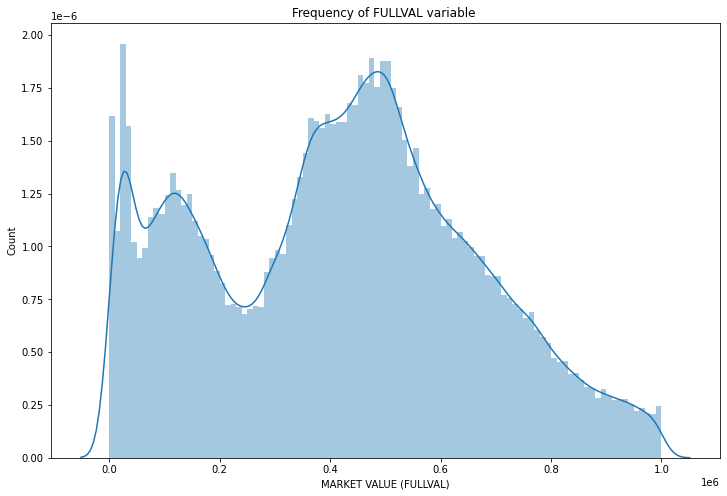

/home/trusted-service-user/cluster-env/env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

In [30]:
xhigh = 1000000
plt.figure(figsize=(12,8))
temp = d[d['FULLVAL'] <= xhigh]
sns.distplot(temp['FULLVAL'],bins=100)
plt.ylabel('Count')
plt.title('Frequency of FULLVAL variable ')
plt.xlabel('MARKET VALUE (FULLVAL)')
plt.show()

StatementMeta(#SPARK_POOL_NAME#, 42, 31, Finished, Available)

False    655251
True       8025
Name: FULLVAL2, dtype: int64


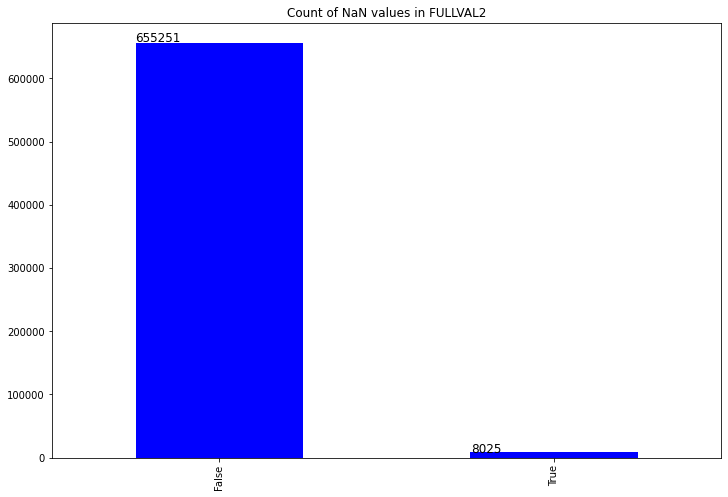

In [31]:
# This group consists of three sub-groups namely ZIP, TAX CLASS, and Building Class.
#We fill with the median of that group as the distribution is skewed.


d['FULLVAL2']=d['FULLVAL'].fillna(d.groupby(["ZIP","TAXCLASS","BLDGCL"])['FULLVAL'].transform(f_fullval))

print(d['FULLVAL2'].isnull().value_counts())


fig = plt.figure(figsize=(12,8))
plt.title('Count of NaN values in FULLVAL2')
my_colors = ['b', 'b']
ax = d['FULLVAL2'].isnull().value_counts().plot(kind='bar',color=my_colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),fontsize = 12)

plt.show()

#This graph shows the NA values as 'True' and filled values as 'False'

StatementMeta(#SPARK_POOL_NAME#, 42, 32, Finished, Available)

False    660643
True       2633
Name: FULLVAL3, dtype: int64


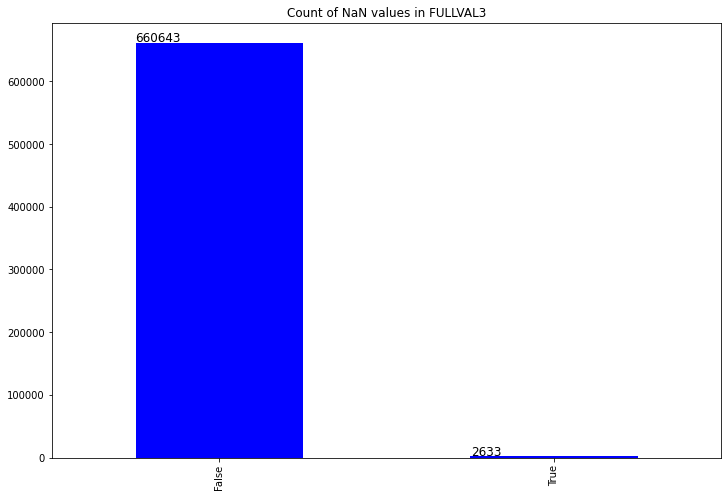

In [32]:
# This group consists of two broader sub-groups namely ZIP and TAX CLASS, dropped Buidling Class.
d["FULLVAL3"]=d['FULLVAL2'].fillna(d.groupby(["ZIP","TAXCLASS"])['FULLVAL2'].transform(f_fullval))
# Filled 6061 NA values
print(d['FULLVAL3'].isnull().value_counts())

fig = plt.figure(figsize=(12,8))
plt.title('Count of NaN values in FULLVAL3')
my_colors = ['b', 'b']
ax = d['FULLVAL3'].isnull().value_counts().plot(kind='bar',color=my_colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),fontsize = 12)

plt.show()

#The graph shows the values that are NA as 'True' and filled values as 'False'

StatementMeta(#SPARK_POOL_NAME#, 42, 33, Finished, Available)

False    663270
True          6
Name: FULLVAL4, dtype: int64


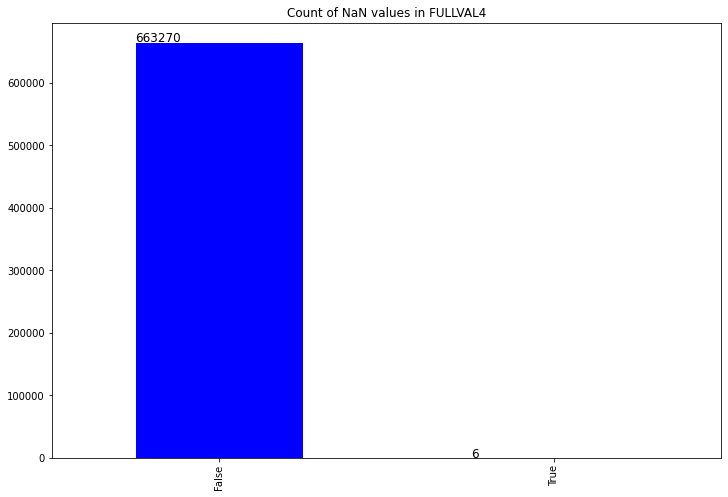

In [33]:
# This group consists of grouping by ZIP only
d["FULLVAL4"]=d['FULLVAL3'].fillna(d.groupby(["ZIP"])['FULLVAL3'].transform(f_fullval)) 
# Filled 4456 NA values
print(d['FULLVAL4'].isnull().value_counts())

fig = plt.figure(figsize=(12,8))
plt.title('Count of NaN values in FULLVAL4')
my_colors = ['b', 'b']
ax = d['FULLVAL4'].isnull().value_counts().plot(kind='bar',color=my_colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),fontsize = 12)

plt.show()

#This graph shows the plot for the values with NA values as 'True' and Filled values as 'True'

StatementMeta(#SPARK_POOL_NAME#, 42, 34, Finished, Available)

False    663276
Name: FULLVAL5, dtype: int64


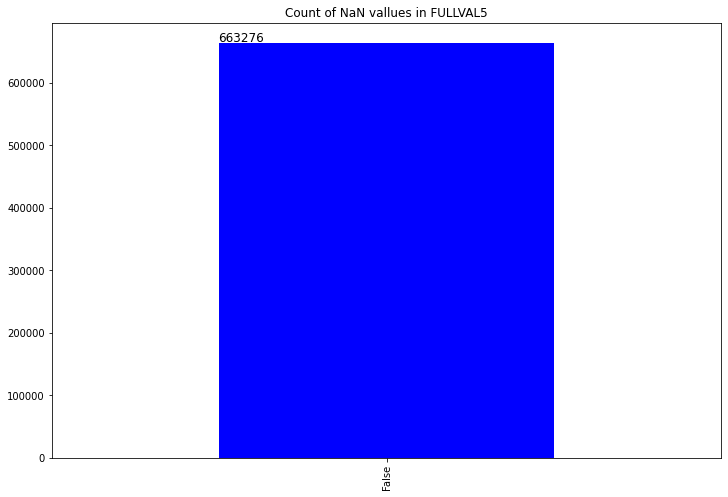

In [34]:

# Finally, grouping by TAXCLASS only
d["FULLVAL5"]=d['FULLVAL4'].fillna(d.groupby(["TAXCLASS"])['FULLVAL4'].transform(f_fullval)) 
# All NA values removed
print(d['FULLVAL5'].isnull().value_counts())

fig = plt.figure(figsize=(12,8))
plt.title('Count of NaN vallues in FULLVAL5')
my_colors = ['b', 'b']
ax = d['FULLVAL5'].isnull().value_counts().plot(kind='bar',color=my_colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),fontsize = 12)

plt.show()

#This graph shows the plot for the values that are NA as 'True' and Filled values as 'False'

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; *Frequency of Market Value Variable (FULLVAL5)*

StatementMeta(#SPARK_POOL_NAME#, 42, 35, Finished, Available)

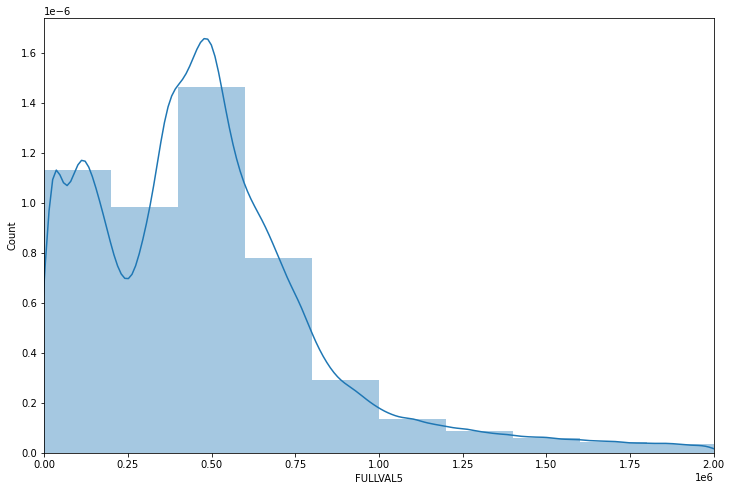

/home/trusted-service-user/cluster-env/env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

In [35]:
# Final distribution of FullVal after filling NA values
xhigh = 2000000

plt.figure(figsize=(12,8))
plt.xlim(0,xhigh)
temp = d[d['FULLVAL5'] <= xhigh]
sns.distplot(temp['FULLVAL5'],bins=10)
plt.ylabel('Count')
plt.show()

#### Data Imputation for Actual Land Value

 &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; *Frequency of Actual Land Value variable*

StatementMeta(#SPARK_POOL_NAME#, 42, 36, Finished, Available)

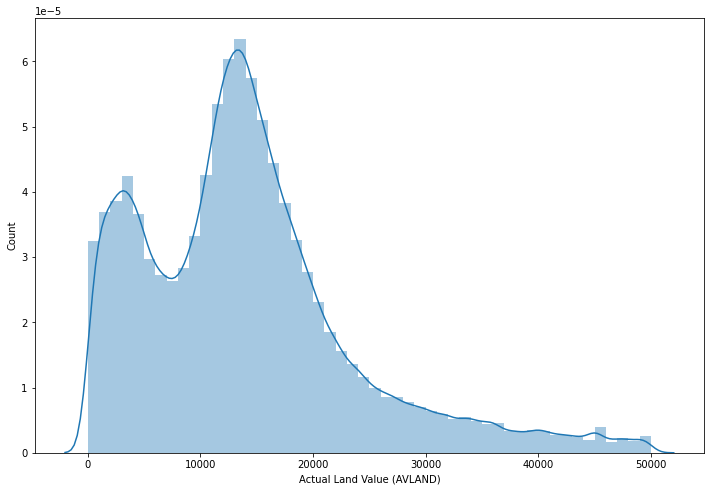

/home/trusted-service-user/cluster-env/env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

In [36]:
# Original Distribution of AVLAND
xhigh = 50000

plt.figure(figsize=(12,8))
temp = d[d['AVLAND'] <= xhigh]
sns.distplot(temp['AVLAND'],bins=50)
plt.ylabel('Count')
plt.xlabel('Actual Land Value (AVLAND)')
plt.show()

StatementMeta(#SPARK_POOL_NAME#, 42, 37, Finished, Available)

False    655251
True       8025
Name: AVLAND2, dtype: int64


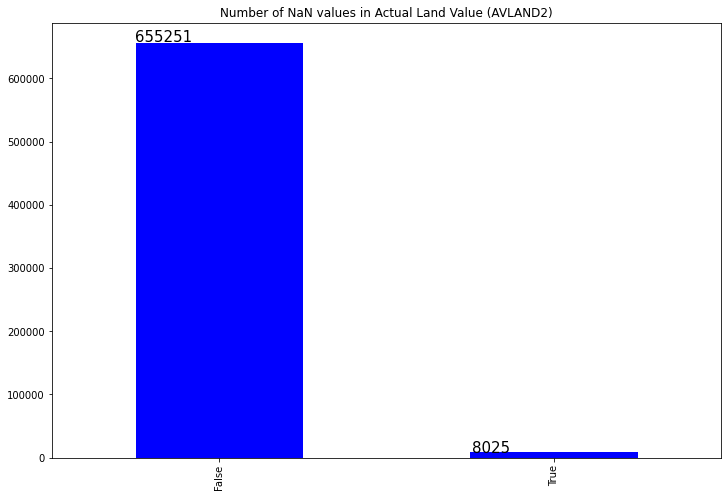

In [37]:

# This group consists of three sub-groups namely ZIP, TAX CLASS, and Building Class. We fill with the median of that group as the distribution is skewed.
d['AVLAND2']=d['AVLAND'].fillna(d.groupby(["ZIP","TAXCLASS","BLDGCL"])['AVLAND'].transform(f_fullval))
print(d['AVLAND2'].isnull().value_counts())


fig = plt.figure(figsize=(12,8))
plt.title('Number of NaN values in Actual Land Value (AVLAND2)')
my_colors = ['b', 'b']
ax = d['AVLAND2'].isnull().value_counts().plot(kind='bar',color=my_colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),fontsize = 15)

plt.show()

StatementMeta(#SPARK_POOL_NAME#, 42, 38, Finished, Available)

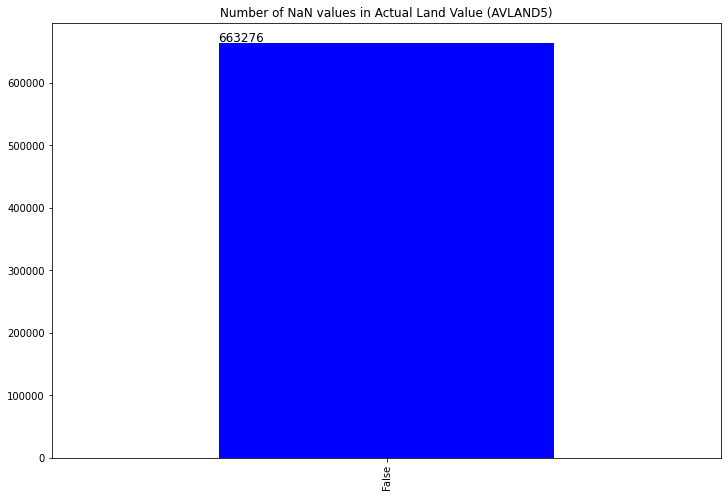

In [38]:
# Similar to the Full Value, grouping by ZIP and Tax class first
d['AVLAND3']=d['AVLAND2'].fillna(d.groupby(["ZIP","TAXCLASS"])['AVLAND2'].transform(f_fullval))


# Grouping by ZIP
d['AVLAND4']=d['AVLAND3'].fillna(d.groupby(["ZIP"])['AVLAND3'].transform(f_fullval))

# Grouping by Taxclass only
d['AVLAND5']=d['AVLAND4'].fillna(d.groupby(["TAXCLASS"])['AVLAND4'].transform(f_fullval))
d['AVLAND5'].isnull().value_counts()

fig = plt.figure(figsize=(12,8))
plt.title('Number of NaN values in Actual Land Value (AVLAND5)')
my_colors = ['b', 'b']
ax = d['AVLAND5'].isnull().value_counts().plot(kind='bar',color=my_colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),fontsize = 12)

plt.show()

#The graph shows the number of NA values as 'True' and Filled values as 'False'


StatementMeta(#SPARK_POOL_NAME#, 42, 39, Finished, Available)

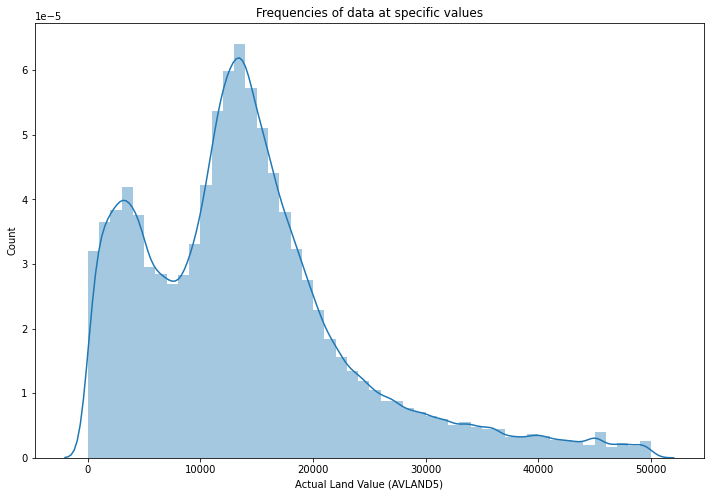

/home/trusted-service-user/cluster-env/env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

In [39]:
# Final distribution of FullVal after filling NA values


xhigh = 50000
plt.figure(figsize=(12,8))

temp = d[d['AVLAND5'] <= xhigh]
sns.distplot(temp['AVLAND5'],bins=50)
plt.title('Frequencies of data at specific values')
plt.ylabel('Count') 
plt.xlabel('Actual Land Value (AVLAND5)')
plt.show()

##### &emsp;&emsp;&emsp;&emsp; DATA IMPUTATION FOR Actual Total Value

StatementMeta(#SPARK_POOL_NAME#, 42, 40, Finished, Available)

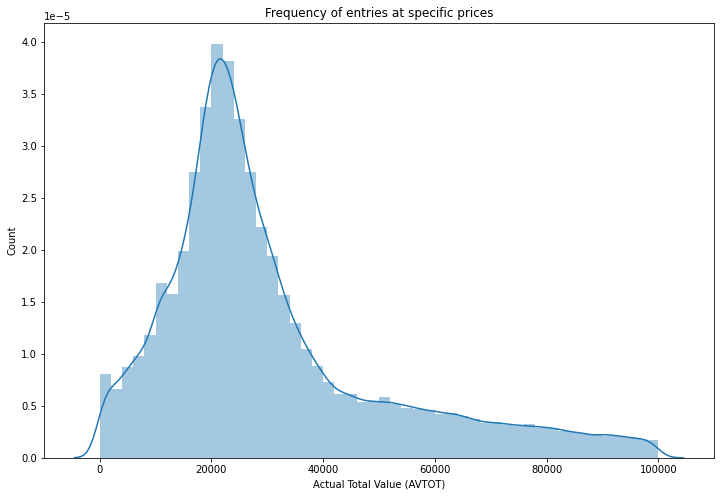

/home/trusted-service-user/cluster-env/env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

In [40]:
# Original distribution of ACTUAL TOTAL VALUE (Variable name 'AVTOT')


xhigh = 100000
plt.figure(figsize=(12,8))
plt.title('Frequency of entries at specific prices')
temp = d[d['AVTOT'] <= xhigh]
sns.distplot(temp['AVTOT'],bins=50,)
plt.ylabel('Count')
plt.xlabel('Actual Total Value (AVTOT)')
plt.show()

In [41]:
# This group consists of three sub-groups namely ZIP, TAX CLASS, and Building Class. 


# We fill with the median of that group as the distribution is skewed.


d['AVTOT2']=d['AVTOT'].fillna(d.groupby(["ZIP","TAXCLASS","BLDGCL"])['AVTOT'].transform(f_fullval))

StatementMeta(#SPARK_POOL_NAME#, 42, 41, Finished, Available)

In [42]:
# Similar to the Full Value, grouping by ZIP and Tax class first

d['AVTOT3']=d['AVTOT2'].fillna(d.groupby(["ZIP","TAXCLASS"])['AVTOT2'].transform(f_fullval))




# Grouping by ZIP

d['AVTOT4']=d['AVTOT3'].fillna(d.groupby(["ZIP"])['AVTOT3'].transform(f_fullval))




# Grouping by Taxclass only

d['AVTOT5']=d['AVTOT4'].fillna(d.groupby(["TAXCLASS"])['AVTOT4'].transform(f_fullval))

# All NaN values filled

StatementMeta(#SPARK_POOL_NAME#, 42, 42, Finished, Available)

StatementMeta(#SPARK_POOL_NAME#, 42, 43, Finished, Available)

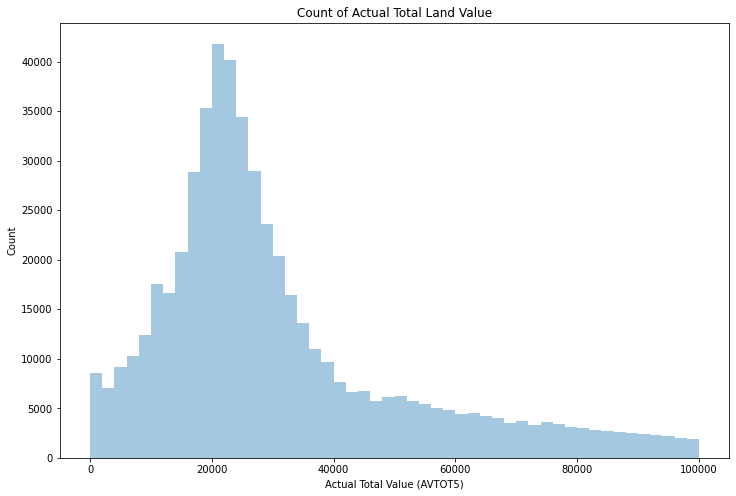

/home/trusted-service-user/cluster-env/env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

In [43]:
xhigh = 100000
plt.figure(figsize=(12,8))
temp = d[d['AVTOT5'] <= xhigh]
sns.distplot(temp['AVTOT5'],bins=50, kde=False)
plt.title('Count of Actual Total Land Value')
plt.ylabel('Count')
plt.xlabel('Actual Total Value (AVTOT5)')
plt.show()

In [44]:
# Dropping Unfilled Columns


d1=d.drop(["FULLVAL","FULLVAL2","FULLVAL3","FULLVAL4","AVLAND",
        "AVLAND2","AVLAND3","AVLAND4","AVTOT","AVTOT2","AVTOT3",
        "AVTOT4"],axis=1)

StatementMeta(#SPARK_POOL_NAME#, 42, 44, Finished, Available)

In [45]:
# Renaming the columns back to original names


d1=d1.rename(columns={"FULLVAL5":"FULLVAL","AVLAND5":"AVLAND","AVTOT5":"AVTOT"})

StatementMeta(#SPARK_POOL_NAME#, 42, 45, Finished, Available)

#### &emsp;&emsp;&emsp;&emsp;DATA IMPUTATION FOR Lot Width

In [46]:

df2 = deepcopy(d1)
#check how many null value and 0 in LTFRONT
attribute = 'LTFRONT'
print('Null Value Number Counts')
print(df2[attribute].isnull().sum())

print('0 Value Counts')
print(len(df2.loc[df2[attribute] == 0]))

StatementMeta(#SPARK_POOL_NAME#, 42, 46, Finished, Available)

Null Value Number Counts
0
0 Value Counts
145137

In [47]:
#generate a dataset non0 in which all LTFRONT has values
non0 = df2[df2[attribute] != 0].copy()  
#define a function f_mode to get the mode (list unique values and count numbers of each value, then take the frist unique value)
def f_mode (x):
    return x.value_counts().index[0]

StatementMeta(#SPARK_POOL_NAME#, 42, 47, Finished, Available)

In [48]:
#generate dataset non0_LTFR which includes LTFRONT, ZIP and BLDGCL
non0_LTFR = non0[[attribute, 'ZIP','BLDGCL']].copy()


#group by ZIP and BLDGL and get the mode of LTFRONT for each group
temp = non0_LTFR.groupby(['ZIP','BLDGCL'])[[attribute]].agg(f_mode).copy()
temp

StatementMeta(#SPARK_POOL_NAME#, 42, 48, Finished, Available)

LTFRONT
ZIP     BLDGCL         
10001.0 A4           19
        A5           18
        A9           15
        B9           15
        C0           18
...                 ...
11422.0 Z7          999
11691.0 G7          141
11692.0 R0           98
33803.0 G7           20
        V0           40

[10813 rows x 1 columns]

In [49]:

#locate the record with same ZIP and BLDGCL and replace 0 with the mode


for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        temp_BLDGCL = df2.loc[i,'BLDGCL']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,].loc[temp_BLDGCL,attribute]
    except:
        continue

df2.head(5)

StatementMeta(#SPARK_POOL_NAME#, 42, 49, Finished, Available)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,FULLVAL,AVLAND,AVTOT
0,1,1,Y4,4,198,0,50.0,96228900.0,136818900.0,1 GOVERNORS ISLAND,10004.0,0.0,0.0,304042000.0,96228900.0,136818900.0
1,1,1,P7,4,500,1046,50.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,0.0,0.0,21400000.0,4225500.0,9630000.0
2,1,1,Z9,4,27,0,50.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,0.0,0.0,193800000.0,14310000.0,87210000.0
3,1,2,Y7,4,709,564,3.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709.0,564.0,104686000.0,39008700.0,47108700.0
4,1,2,T2,4,793,551,2.0,15255000.0,17640000.0,PIER 6,10004.0,85.0,551.0,39200000.0,15255000.0,17640000.0


In [50]:
#check how many 0 still left in LTFRONT
print(len(df2.loc[df2[attribute] == 0]))

StatementMeta(#SPARK_POOL_NAME#, 42, 50, Finished, Available)

11234

In [51]:
#group by ZIP and relace 0 by mode in the same ZIP group
non0_LTFR = non0[[attribute, 'ZIP']].copy()
temp = non0_LTFR.groupby(['ZIP',])[[attribute]].agg(f_mode).copy()
temp

StatementMeta(#SPARK_POOL_NAME#, 42, 51, Finished, Available)

,LTFRONT
ZIP,
10001.0,25
10002.0,25
10003.0,244
10004.0,422
10005.0,197
...,...
11421.0,63
11422.0,999
11691.0,141


In [52]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,attribute]
    except:
        continue

#check how many 0 left in LTFRONT
print(len(df2.loc[df2[attribute] == 0]))

StatementMeta(#SPARK_POOL_NAME#, 42, 52, Finished, Available)

0

#### DATA IMPUTATION OF Lot Depth

In [53]:
#the method to fill up LTDEPTH is same as LTFRONT
attribute = 'LTDEPTH'
print('Null Value Number Counts')
print(df2[attribute].isnull().sum())

print('0 Value Counts')
print(len(df2.loc[df2[attribute] == 0]))

StatementMeta(#SPARK_POOL_NAME#, 42, 53, Finished, Available)

Null Value Number Counts
0
0 Value Counts
146116

In [54]:
#Create a copy of the data with non-zero values

non0 = df2[df2[attribute] != 0].copy()  


StatementMeta(#SPARK_POOL_NAME#, 42, 54, Finished, Available)

In [55]:
#With that non-zero values dataset seperate out ZIP and BLDGCL


non0_LTDP = non0[[attribute, 'ZIP','BLDGCL']].copy()
temp = non0_LTDP.groupby(['ZIP','BLDGCL'])[[attribute]].agg(f_mode).copy()
temp

StatementMeta(#SPARK_POOL_NAME#, 42, 55, Finished, Available)

LTDEPTH
ZIP     BLDGCL         
10001.0 A4           98
        A5           98
        A9           98
        B9           98
        C0           98
...                 ...
11422.0 Z7          519
11691.0 G7          115
11692.0 R0          100
33803.0 G7          118
        V0          118

[10813 rows x 1 columns]

In [56]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        temp_BLDGCL = df2.loc[i,'BLDGCL']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,].loc[temp_BLDGCL,attribute]
    except:
        continue

df2.head(5)

StatementMeta(#SPARK_POOL_NAME#, 42, 56, Finished, Available)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,FULLVAL,AVLAND,AVTOT
0,1,1,Y4,4,198,0,50.0,96228900.0,136818900.0,1 GOVERNORS ISLAND,10004.0,0.0,0.0,304042000.0,96228900.0,136818900.0
1,1,1,P7,4,500,1046,50.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,0.0,0.0,21400000.0,4225500.0,9630000.0
2,1,1,Z9,4,27,177,50.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,0.0,0.0,193800000.0,14310000.0,87210000.0
3,1,2,Y7,4,709,564,3.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709.0,564.0,104686000.0,39008700.0,47108700.0
4,1,2,T2,4,793,551,2.0,15255000.0,17640000.0,PIER 6,10004.0,85.0,551.0,39200000.0,15255000.0,17640000.0


In [57]:
print(len(df2.loc[df2[attribute] == 0]))

non0_LTDP = non0[[attribute, 'ZIP']].copy()
temp = non0_LTDP.groupby(['ZIP',])[[attribute]].agg(f_mode).copy()
temp

StatementMeta(#SPARK_POOL_NAME#, 42, 57, Finished, Available)

12916


,LTDEPTH
ZIP,
10001.0,98
10002.0,100
10003.0,425
10004.0,355
10005.0,171
...,...
11421.0,87
11422.0,519
11691.0,115


In [58]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,attribute]
    except:
        continue

print(len(df2.loc[df2[attribute] == 0]))


StatementMeta(#SPARK_POOL_NAME#, 42, 58, Finished, Available)

0

#### &emsp;&emsp;&emsp;&emsp; Data Imputation for Building Width

In [59]:
#the method to fill up BLDFRONT is same as what we did with LTFRONT
attribute = 'BLDFRONT'
print('Null Value Number Counts')
print(df2[attribute].isnull().sum())

print('0 Value Counts')
print(len(df2.loc[df2[attribute] == 0]))

StatementMeta(#SPARK_POOL_NAME#, 42, 59, Finished, Available)

Null Value Number Counts
1
0 Value Counts
180749

In [60]:
non0 = df2[df2[attribute] != 0].copy()  


#group together ZIP and BLDGCL variables to BLDFRONT
non0_BDFR = non0[[attribute, 'ZIP','BLDGCL']].copy()
temp = non0_BDFR.groupby(['ZIP','BLDGCL'])[[attribute]].agg(f_mode).copy()
temp

StatementMeta(#SPARK_POOL_NAME#, 42, 60, Finished, Available)

BLDFRONT
ZIP     BLDGCL          
10001.0 A4          19.0
        A5          18.0
        A9          18.0
        B9          19.0
        C0          18.0
...                  ...
11421.0 G7          54.0
        W1          93.0
11422.0 D1          30.0
        F9          40.0
11692.0 R0          58.0

[9542 rows x 1 columns]

In [61]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        temp_BLDGCL = df2.loc[i,'BLDGCL']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,].loc[temp_BLDGCL,attribute]
    except:
        continue

df2.head(5)

StatementMeta(#SPARK_POOL_NAME#, 42, 61, Finished, Available)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,FULLVAL,AVLAND,AVTOT
0,1,1,Y4,4,198,355,50.0,96228900.0,136818900.0,1 GOVERNORS ISLAND,10004.0,0.0,0.0,304042000.0,96228900.0,136818900.0
1,1,1,P7,4,500,1046,50.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,41.0,0.0,21400000.0,4225500.0,9630000.0
2,1,1,Z9,4,27,177,50.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,37.0,0.0,193800000.0,14310000.0,87210000.0
3,1,2,Y7,4,709,564,3.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709.0,564.0,104686000.0,39008700.0,47108700.0
4,1,2,T2,4,793,551,2.0,15255000.0,17640000.0,PIER 6,10004.0,85.0,551.0,39200000.0,15255000.0,17640000.0


In [62]:
print(len(df2.loc[df2[attribute] == 0]))
non0_BDFR = non0[[attribute, 'ZIP']].copy()
temp = non0_BDFR.groupby(['ZIP',])[[attribute]].agg(f_mode).copy()
temp

StatementMeta(#SPARK_POOL_NAME#, 42, 62, Finished, Available)

46088


,BLDFRONT
ZIP,
10001.0,25.0
10002.0,25.0
10003.0,25.0
10004.0,132.0
10005.0,151.0
...,...
11417.0,20.0
11420.0,35.0
11421.0,54.0


In [63]:

for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,attribute]
    except:
        continue

print(len(df2.loc[df2[attribute] == 0]))

non0_BDFR = non0[[attribute, 'B']].copy()
temp = non0_BDFR.groupby(['B',])[[attribute]].agg(f_mode).copy()
temp

StatementMeta(#SPARK_POOL_NAME#, 42, 63, Finished, Available)

192


,BLDFRONT
B,
1,25.0
2,20.0
3,20.0
4,20.0


In [64]:

for i in df2[df2[attribute] == 0].index:
    try:
        temp_B = df2.loc[i,'B']
        df2.loc[i, attribute] = temp.loc[temp_B,attribute]
    except:
        continue

print(len(df2.loc[df2[attribute] == 0]))


StatementMeta(#SPARK_POOL_NAME#, 42, 64, Finished, Available)

0

#### &emsp;&emsp;&emsp;&emsp;Data Imputation for Building Depth (Variable 'BLDDEPTH')

In [65]:
#the method to fill up BLDDEPTH is same as LTFRONT
attribute = 'BLDDEPTH'
print('Null Value Number Counts')
print(df2[attribute].isnull().sum())

print('0 Value Counts')
print(len(df2.loc[df2[attribute] == 0]))

StatementMeta(#SPARK_POOL_NAME#, 42, 65, Finished, Available)

Null Value Number Counts
1
0 Value Counts
180772

In [66]:
non0 = df2[df2[attribute] != 0].copy()  

non0_BDDP = non0[[attribute, 'ZIP','BLDGCL']].copy()
temp = non0_BDDP.groupby(['ZIP','BLDGCL'])[[attribute]].agg(f_mode).copy()
temp

StatementMeta(#SPARK_POOL_NAME#, 42, 66, Finished, Available)

BLDDEPTH
ZIP     BLDGCL          
10001.0 A4          36.0
        A5          46.0
        A9          50.0
        B9          33.0
        C0          44.0
...                  ...
11421.0 G7          46.0
        W1          97.0
11422.0 D1         125.0
        F9          90.0
11692.0 R0          56.0

[9535 rows x 1 columns]

In [67]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        temp_BLDGCL = df2.loc[i,'BLDGCL']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,].loc[temp_BLDGCL,attribute]
    except:
        continue

df2.head(5)

StatementMeta(#SPARK_POOL_NAME#, 42, 67, Finished, Available)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,FULLVAL,AVLAND,AVTOT
0,1,1,Y4,4,198,355,50.0,96228900.0,136818900.0,1 GOVERNORS ISLAND,10004.0,132.0,0.0,304042000.0,96228900.0,136818900.0
1,1,1,P7,4,500,1046,50.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,41.0,63.0,21400000.0,4225500.0,9630000.0
2,1,1,Z9,4,27,177,50.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,37.0,227.0,193800000.0,14310000.0,87210000.0
3,1,2,Y7,4,709,564,3.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709.0,564.0,104686000.0,39008700.0,47108700.0
4,1,2,T2,4,793,551,2.0,15255000.0,17640000.0,PIER 6,10004.0,85.0,551.0,39200000.0,15255000.0,17640000.0


In [68]:
print(len(df2.loc[df2[attribute] == 0]))

non0_BDDP = non0[[attribute, 'ZIP']].copy()
temp = non0_BDDP.groupby(['ZIP',])[[attribute]].agg(f_mode).copy()
temp

StatementMeta(#SPARK_POOL_NAME#, 42, 68, Finished, Available)

46104


,BLDDEPTH
ZIP,
10001.0,98.0
10002.0,88.0
10003.0,100.0
10004.0,115.0
10005.0,149.0
...,...
11417.0,28.0
11420.0,99.0
11421.0,46.0


In [69]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,attribute]
    except:
        continue

print(len(df2.loc[df2[attribute] == 0]))


StatementMeta(#SPARK_POOL_NAME#, 42, 69, Finished, Available)

192

In [70]:
non0_BDDP = non0[[attribute, 'B']].copy()
temp = non0_BDDP.groupby(['B',])[[attribute]].agg(f_mode).copy()
temp



StatementMeta(#SPARK_POOL_NAME#, 42, 70, Finished, Available)

,BLDDEPTH
B,
1,100.0
2,50.0
3,50.0
4,50.0


In [71]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_B = df2.loc[i,'B']
        df2.loc[i, attribute] = temp.loc[temp_B,attribute]
    except:
        continue

print(len(df2.loc[df2[attribute] == 0]))


StatementMeta(#SPARK_POOL_NAME#, 42, 71, Finished, Available)

0

#### &emsp;&emsp;&emsp;&emsp;Verify Data Imputation 
&emsp;&emsp;&emsp;&emsp; *Verify all appropriate data fields have been filled and then output to a CSV file*

In [72]:
# Verify all the data fields have been filled in df2, and there are no missing values
# column headers in df2

fields = df2.columns 
for item in fields:
  print(item, ';         NaN: ', len(df2.loc[df2[item].isna()]), "; 0's: ",len(df2.loc[df2[item]==0]))

StatementMeta(#SPARK_POOL_NAME#, 42, 72, Finished, Available)

B ;         NaN:  0 ; 0's:  0
BLOCK ;         NaN:  0 ; 0's:  0
BLDGCL ;         NaN:  0 ; 0's:  0
TAXCLASS ;         NaN:  0 ; 0's:  0
LTFRONT ;         NaN:  0 ; 0's:  0
LTDEPTH ;         NaN:  0 ; 0's:  0
STORIES ;         NaN:  0 ; 0's:  0
EXLAND ;         NaN:  0 ; 0's:  349388
EXTOT ;         NaN:  0 ; 0's:  298906
STADDR ;         NaN:  389 ; 0's:  0
ZIP ;         NaN:  0 ; 0's:  0
BLDFRONT ;         NaN:  1 ; 0's:  0
BLDDEPTH ;         NaN:  1 ; 0's:  0
FULLVAL ;         NaN:  0 ; 0's:  0
AVLAND ;         NaN:  0 ; 0's:  0
AVTOT ;         NaN:  0 ; 0's:  0

In [73]:
# Copy all the fully imputed fields into the full dataset as we had dropped the columns earlier from df2 and output to a csv file


df_full = deepcopy(data)

for item in fields:
  df_full[item] = df2[item]

for item in fields:
  print(item, '; NaN:', len(df_full.loc[df_full[item].isna()]), "; 0's:",len(df_full.loc[df_full[item]==0]))

StatementMeta(#SPARK_POOL_NAME#, 42, 73, Finished, Available)

B ; NaN: 0 ; 0's: 0
BLOCK ; NaN: 0 ; 0's: 0
BLDGCL ; NaN: 0 ; 0's: 0
TAXCLASS ; NaN: 0 ; 0's: 0
LTFRONT ; NaN: 0 ; 0's: 0
LTDEPTH ; NaN: 0 ; 0's: 0
STORIES ; NaN: 0 ; 0's: 0
EXLAND ; NaN: 0 ; 0's: 349388
EXTOT ; NaN: 0 ; 0's: 298906
STADDR ; NaN: 389 ; 0's: 0
ZIP ; NaN: 0 ; 0's: 0
BLDFRONT ; NaN: 1 ; 0's: 0
BLDDEPTH ; NaN: 1 ; 0's: 0
FULLVAL ; NaN: 0 ; 0's: 0
AVLAND ; NaN: 0 ; 0's: 0
AVTOT ; NaN: 0 ; 0's: 0

In [74]:
fields_all = data.columns
for item in fields_all:
  print(item, "; NaN's =", len(df_full.loc[df_full[item].isna()]), "; Zero's =",len(df_full.loc[df_full[item]==0]))

StatementMeta(#SPARK_POOL_NAME#, 42, 74, Finished, Available)

BBLE ; NaN's = 0 ; Zero's = 0
B ; NaN's = 0 ; Zero's = 0
BLOCK ; NaN's = 0 ; Zero's = 0
LOT ; NaN's = 0 ; Zero's = 0
EASEMENT ; NaN's = 661266 ; Zero's = 0
OWNER ; NaN's = 25262 ; Zero's = 0
BLDGCL ; NaN's = 0 ; Zero's = 0
TAXCLASS ; NaN's = 0 ; Zero's = 0
LTFRONT ; NaN's = 0 ; Zero's = 0
LTDEPTH ; NaN's = 0 ; Zero's = 0
EXT ; NaN's = 513594 ; Zero's = 0
STORIES ; NaN's = 0 ; Zero's = 0
FULLVAL ; NaN's = 0 ; Zero's = 0
AVLAND ; NaN's = 0 ; Zero's = 0
AVTOT ; NaN's = 0 ; Zero's = 0
EXLAND ; NaN's = 0 ; Zero's = 349388
EXTOT ; NaN's = 0 ; Zero's = 298906
EXCD1 ; NaN's = 298844 ; Zero's = 0
STADDR ; NaN's = 389 ; Zero's = 0
ZIP ; NaN's = 0 ; Zero's = 0
EXMPTCL ; NaN's = 652989 ; Zero's = 0
BLDFRONT ; NaN's = 1 ; Zero's = 0
BLDDEPTH ; NaN's = 1 ; Zero's = 0
AVLAND2 ; NaN's = 420959 ; Zero's = 0
AVTOT2 ; NaN's = 420959 ; Zero's = 0
EXLAND2 ; NaN's = 589379 ; Zero's = 0
EXTOT2 ; NaN's = 548909 ; Zero's = 0
EXCD2 ; NaN's = 615052 ; Zero's = 0
PERIOD ; NaN's = 1 ; Zero's = 0
YEAR ; NaN's = 1 ;

## Output the data into a CSV file and upload it to Azure Blob Storage

In [75]:
output = df_full.to_csv (index=False, header=True, encoding = "utf-8")

CONNECTIONSTRING = 'DefaultEndpointsProtocol=https;AccountName=#STORAGE_ACCOUNT_NAME#;AccountKey=#STORAGE_ACCOUNT_KEY#;EndpointSuffix=core.windows.net'
CONTAINER_NAME = 'fraud-detection-sample-nyrealestate'

blobName = "Fraud_Detection_NYC_Data.csv"
blob = BlobClient.from_connection_string(conn_str=CONNECTIONSTRING, container_name=CONTAINER_NAME, blob_name=blobName)
try:
    blob.upload_blob(output)
except: 
    print("Blob already exists, no need to update")

StatementMeta(#SPARK_POOL_NAME#, 42, 75, Finished, Available)

Blob already exists, no need to update